In [1]:
# 1-1 Structured Data
# TITANIC数据集预测乘客是否生还 https://www.kaggle.com/c/titanic/overview
# https://zhuanlan.zhihu.com/p/1892689363609032087
# https://github.com/lyhue1991/eat_pytorch_in_20_days/blob/master/1-1%2C%E7%BB%93%E6%9E%84%E5%8C%96%E6%95%B0%E6%8D%AE%E5%BB%BA%E6%A8%A1%E6%B5%81%E7%A8%8B%E8%8C%83%E4%BE%8B.ipynb
# https://github.com/lyhue1991/torchkeras
# https://www.heywhale.com/mw/project/5f2b493eaf3980002cb1ced0
# https://www.bilibili.com/video/BV1Ua411P7oe
import os, sys
import datetime
import torch
import torchkeras
import random
import numpy as np
import pandas as pd
from torchkeras.metrics import Accuracy
from tqdm import tqdm
from copy import deepcopy
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from matplotlib import pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


set_seed(88)
print(torch.__version__)
print(torchkeras.__version__)
print(f"全局默认数据类型：{torch.get_default_dtype()}")

2.6.0+cu126
4.0.4
全局默认数据类型：torch.float32


In [4]:
data = np.array([1, 2, 3])
upper_tensor = torch.Tensor(data)
lower_tensor = torch.tensor(data)
print(f"上界张量：{upper_tensor}")
print(f"下界张量：{lower_tensor}")
type(upper_tensor), type(lower_tensor)

上界张量：tensor([1., 2., 3.])
下界张量：tensor([1, 2, 3])


(torch.Tensor, torch.Tensor)

In [10]:
data = np.array([1, 2, 3])
numpy_tensor = torch.from_numpy(data)
print(f"numpy_tensor：{numpy_tensor}")
data[0] = 100
print(f"numpy_tensor：{numpy_tensor}")
type(numpy_tensor)

numpy_tensor：tensor([1, 2, 3])
numpy_tensor：tensor([100,   2,   3])


torch.Tensor

In [2]:
data_dir = '../../data/kaggle-titanic/'
train_raw = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_raw = pd.read_csv(os.path.join(data_dir, 'test.csv'))
gender_submission_raw = pd.read_csv(os.path.join(data_dir, 'gender_submission.csv'))
print(f"训练数据预览：\n{train_raw.head(5)}")
print("-" * 100)
print(f"测试数据预览：\n{test_raw.head(5)}")
print("-" * 100)
print(f"提交样例预览：\n{gender_submission_raw.head(5)}")

训练数据预览：
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN      

In [10]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Text(0, 0.5, 'Counts')

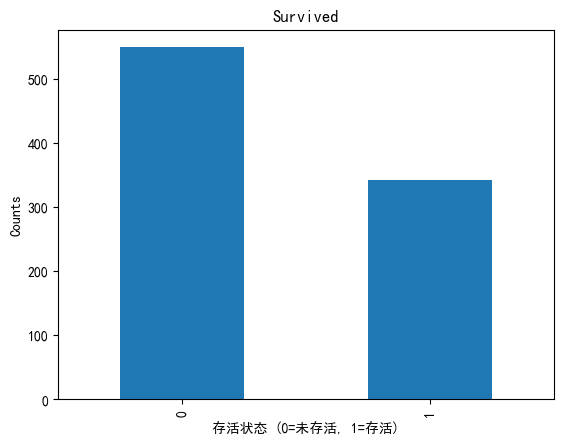

In [19]:
# 获救情况分布
ax = train_raw['Survived'].value_counts().plot(kind='bar')
ax.set_title('Survived')
ax.set_xlabel('存活状态 (0=未存活, 1=存活)')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

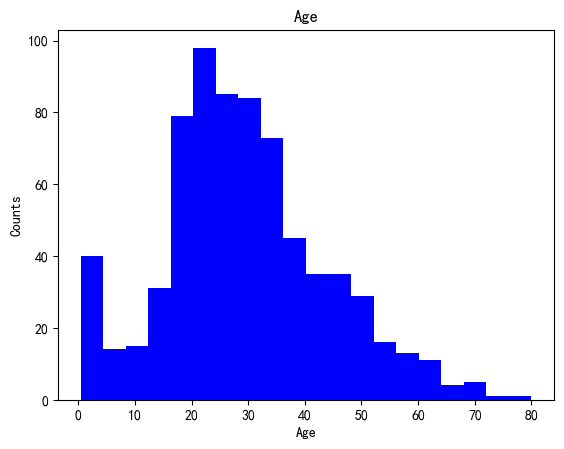

In [24]:
# 年龄分布
ax = train_raw['Age'].plot(kind='hist', bins=20, color='b')
ax.set_title('Age')
ax.set_xlabel('Age')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Density')

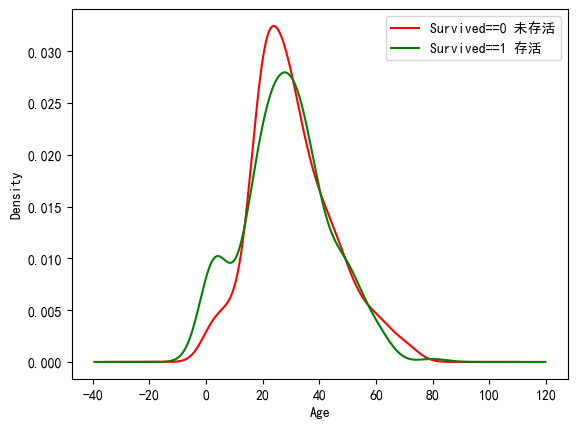

In [31]:
# 年龄与存活情况的关系
ax = train_raw.query('Survived == 0')['Age'].plot(kind='density', color='r', label='未存活')
train_raw.query('Survived == 1')['Age'].plot(kind='density', color='g', label='存活')
ax.legend(['Survived==0 未存活', 'Survived==1 存活'])
ax.set_xlabel('Age')
ax.set_ylabel('Density')

In [20]:
# 表格数据预处理
df_raw = train_raw.copy()
train_df = pd.DataFrame()

# Sex - 转换为独热编码
df_sex = pd.get_dummies(df_raw['Sex']).astype(float)
train_df = pd.concat([train_df, df_sex], axis=1)
print(f"性别编码：\n{df_sex.tail(5)}")
print("-" * 100)

# Pclass=ticket class 是一个分类变量，表示乘客的舱位等级（1=头等舱，2=二等舱，3=三等舱）
# Pclass - 转换为独热编码
df_pclass = pd.get_dummies(df_raw['Pclass'],
                           prefix='Pclass').astype(float)
train_df = pd.concat([train_df, df_pclass], axis=1)
print(f"舱位等级独热编码：\n{df_pclass.tail(5)}")
print("-" * 100)

# Age - 填充缺失值
# 按照"Pclass"(船舱等级)和"Sex"(性别)的相似性，对年龄进行中位数填充
# 某些"Pclass"(船舱等级)和"Sex"(性别)的组别仍然没有数据，导致中位数为NaN
train_df['Age_null'] = df_raw['Age'].isnull().astype(float)  # True → 1.0，False → 0.0
age_median_by_group = df_raw.groupby(['Pclass', 'Sex'])['Age'].transform('median')
age_median_overall = df_raw['Age'].median()
train_df['Age'] = df_raw['Age'].fillna(age_median_by_group)
train_df['Age'] = train_df['Age'].fillna(age_median_overall)

# Age Categories - 将年龄分为几个区间
age_bins = [float('-inf'), 12, 20, 40, 60, float('inf')]
age_categories = ['Child', 'Teen', 'Adult', 'Senior', 'Elderly']
df_age = pd.get_dummies(pd.cut(train_df['Age'], bins=age_bins, labels=age_categories),
                        prefix='Age').astype(float)
train_df = pd.concat([train_df, df_age], axis=1)
print(f"年龄类比独热编码：\n{df_age.tail(5)}")
print("-" * 100)

# Embarked=ticket port of embarkation 是一个分类变量，表示乘客登船的港口（C=Cherbourg, Q=Queenstown, S=Southampton）
# Embarked - 转换为独热编码
most_embarked = df_raw['Embarked'].mode()[0]
df_embarked = pd.get_dummies(df_raw['Embarked'].fillna(most_embarked),
                             prefix='Embarked').astype(float)
train_df = pd.concat([train_df, df_embarked], axis=1)
print(f"登船港口独热编码：\n{df_embarked.tail(5)}")
print("-" * 100)

# Cabin=cabin number 是一个分类变量，表示乘客的舱位号，缺失值较多
# Cabin包含Deck(甲板)和Number(舱位号)，我们只保留Deck，并将其转换为独热编码
train_df['Cabin_null'] = df_raw['Cabin'].isnull().astype(float)  # True → 1.0，False → 0.0
df_deck = pd.get_dummies(df_raw['Cabin'].str[0],
                         dummy_na=False,
                         prefix='Deck').astype(float)
train_df = pd.concat([train_df, df_deck], axis=1)
print(f"甲板独热编码：\n{df_deck.tail(5)}")
print("-" * 100)

# SibSp=number of siblings/spouses aboard 是一个数值变量，表示乘客在船上的兄弟姐妹/配偶的数量
train_df['SibSp'] = df_raw['SibSp'].astype(float)

# Parch=number of parents/children aboard 是一个数值变量，表示乘客在船上的父母/子女的数量
train_df['Parch'] = df_raw['Parch'].astype(float)

# Family Size 是一个数值变量，表示乘客的家庭规模
train_df['FamilySize'] = df_raw['SibSp'] + df_raw['Parch'] + 1

# 是否单独旅行
train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(float)  # True → 1.0，False → 0.0

# Fare=passenger fare 是一个数值变量，表示乘客的票价
# 按照"Pclass"(船舱等级)对票价进行中位数填充
fare_median_by_group = df_raw.groupby('Pclass')['Fare'].transform('median')
train_df['Fare'] = df_raw['Fare'].fillna(fare_median_by_group)
train_df['Fare'] = np.log1p(train_df['Fare'])

# Ticket frequency - 票号频率
ticket_counts = df_raw['Ticket'].value_counts()
df_ticket = df_raw['Ticket'].map(ticket_counts)
print(f"票号频率：\n{df_ticket.tail(5)}")
print("-" * 100)
train_df['TicketFreq'] = df_ticket.astype(float)

# Name Title - 从乘客姓名中提取称谓
df_title = df_raw['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
title_mapping = {
    "Mr": "Mr",
    "Miss": "Miss",
    "Mrs": "Mrs",
    "Master": "Master",
    "Dr": "Rare",
    "Rev": "Rare",
    "Col": "Rare",
    "Major": "Rare",
    "Mlle": "Miss",
    "Countess": "Rare",
    "Ms": "Miss",
    "Lady": "Rare",
    "Jonkheer": "Rare",
    "Don": "Rare",
    "Dona": "Rare",
    "Mme": "Mrs",
    "Capt": "Rare",
    "Sir": "Rare"
}
df_title = pd.get_dummies(df_title.map(title_mapping).fillna('Rare'),
                          prefix='Title').astype(float)
print(f"称谓独热编码：\n{df_title.tail(5)}")
print("-" * 100)
train_df = pd.concat([train_df, df_title], axis=1)
print(f"处理后的数据表格：\n{train_df.tail(5)}")

性别编码：
     female  male
886     0.0   1.0
887     1.0   0.0
888     1.0   0.0
889     0.0   1.0
890     0.0   1.0
----------------------------------------------------------------------------------------------------
舱位等级独热编码：
     Pclass_1  Pclass_2  Pclass_3
886       0.0       1.0       0.0
887       1.0       0.0       0.0
888       0.0       0.0       1.0
889       1.0       0.0       0.0
890       0.0       0.0       1.0
----------------------------------------------------------------------------------------------------
年龄类比独热编码：
     Age_Child  Age_Teen  Age_Adult  Age_Senior  Age_Elderly
886        0.0       0.0        1.0         0.0          0.0
887        0.0       1.0        0.0         0.0          0.0
888        0.0       0.0        1.0         0.0          0.0
889        0.0       0.0        1.0         0.0          0.0
890        0.0       0.0        1.0         0.0          0.0
----------------------------------------------------------------------------------------------

In [3]:
# 确定好要使用的特征后，封装预处理方法
def preprocess_dataframe(df_input: pd.DataFrame) -> pd.DataFrame:
    df_raw = df_input.copy()
    df_out = pd.DataFrame()

    df_sex = pd.get_dummies(df_raw['Sex']).astype(float)
    df_out = pd.concat([df_out, df_sex], axis=1)
    df_pclass = pd.get_dummies(df_raw['Pclass'],
                               prefix='Pclass').astype(float)
    df_out = pd.concat([df_out, df_pclass], axis=1)
    df_out['Age_null'] = df_raw['Age'].isnull().astype(float)
    age_median_by_group = df_raw.groupby(['Pclass', 'Sex'])['Age'].transform('median')
    age_median_overall = df_raw['Age'].median()
    df_out['Age'] = df_raw['Age'].fillna(age_median_by_group)
    df_out['Age'] = df_out['Age'].fillna(age_median_overall)
    age_bins = [float('-inf'), 12, 20, 40, 60, float('inf')]
    age_categories = ['Child', 'Teen', 'Adult', 'Senior', 'Elderly']
    df_age = pd.get_dummies(pd.cut(df_out['Age'], bins=age_bins, labels=age_categories),
                            prefix='Age').astype(float)
    df_out = pd.concat([df_out, df_age], axis=1)
    most_embarked = df_raw['Embarked'].mode()[0]
    df_embarked = pd.get_dummies(df_raw['Embarked'].fillna(most_embarked),
                                 prefix='Embarked').astype(float)
    df_out = pd.concat([df_out, df_embarked], axis=1)
    df_out['Cabin_null'] = df_raw['Cabin'].isnull().astype(float)
    df_deck = pd.get_dummies(df_raw['Cabin'].str[0],
                             dummy_na=False,
                             prefix='Deck').astype(float)
    df_out = pd.concat([df_out, df_deck], axis=1)
    df_out['SibSp'] = df_raw['SibSp'].astype(float)
    df_out['Parch'] = df_raw['Parch'].astype(float)
    df_out['FamilySize'] = df_raw['SibSp'] + df_raw['Parch'] + 1
    df_out['IsAlone'] = (df_out['FamilySize'] == 1).astype(float)
    fare_median_by_group = df_raw.groupby('Pclass')['Fare'].transform('median')
    df_out['Fare'] = df_raw['Fare'].fillna(fare_median_by_group)
    df_out['Fare'] = np.log1p(df_out['Fare'])
    ticket_counts = df_raw['Ticket'].value_counts()
    df_ticket = df_raw['Ticket'].map(ticket_counts)
    df_out['TicketFreq'] = df_ticket.astype(float)
    df_title = df_raw['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
    title_mapping = {
        "Mr": "Mr",
        "Miss": "Miss",
        "Mrs": "Mrs",
        "Master": "Master",
        "Dr": "Rare",
        "Rev": "Rare",
        "Col": "Rare",
        "Major": "Rare",
        "Mlle": "Miss",
        "Countess": "Rare",
        "Ms": "Miss",
        "Lady": "Rare",
        "Jonkheer": "Rare",
        "Don": "Rare",
        "Dona": "Rare",
        "Mme": "Mrs",
        "Capt": "Rare",
        "Sir": "Rare"
    }
    df_title = pd.get_dummies(df_title.map(title_mapping).fillna('Rare'),
                              prefix='Title').astype(float)
    df_out = pd.concat([df_out, df_title], axis=1)

    return df_out


train_df = preprocess_dataframe(train_raw)
print(f"处理后的训练数据表格：\n{train_df.tail(5)}")
print("-" * 100)
test_df = preprocess_dataframe(test_raw)
print(f"处理后的测试数据表格：\n{test_df.tail(5)}")

处理后的训练数据表格：
     female  male  Pclass_1  Pclass_2  Pclass_3  Age_null   Age  Age_Child  \
886     0.0   1.0       0.0       1.0       0.0       0.0  27.0        0.0   
887     1.0   0.0       1.0       0.0       0.0       0.0  19.0        0.0   
888     1.0   0.0       0.0       0.0       1.0       1.0  21.5        0.0   
889     0.0   1.0       1.0       0.0       0.0       0.0  26.0        0.0   
890     0.0   1.0       0.0       0.0       1.0       0.0  32.0        0.0   

     Age_Teen  Age_Adult  ...  Parch  FamilySize  IsAlone      Fare  \
886       0.0        1.0  ...    0.0           1      1.0  2.639057   
887       1.0        0.0  ...    0.0           1      1.0  3.433987   
888       0.0        1.0  ...    2.0           4      0.0  3.196630   
889       0.0        1.0  ...    0.0           1      1.0  3.433987   
890       0.0        1.0  ...    0.0           1      1.0  2.169054   

     TicketFreq  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  
886         1.0

In [13]:
train_df.columns

Index(['female', 'male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_null', 'Age',
       'Age_Child', 'Age_Teen', 'Age_Adult', 'Age_Senior', 'Age_Elderly',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_null', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'Fare', 'TicketFreq',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'],
      dtype='object')

In [14]:
test_df.columns

Index(['female', 'male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_null', 'Age',
       'Age_Child', 'Age_Teen', 'Age_Adult', 'Age_Senior', 'Age_Elderly',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_null', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'SibSp',
       'Parch', 'FamilySize', 'IsAlone', 'Fare', 'TicketFreq', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'],
      dtype='object')

In [4]:
X_train = train_df.values
y_train = train_raw['Survived'].values
print(X_train.shape, y_train.shape)
X_test = test_df.values
print(X_test.shape)

(891, 35) (891,)
(418, 34)


In [6]:
train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())

# 训练集和验证集划分
TRAIN_RATIO = 0.8
TRAIN_COUNT = int(len(train_set) * TRAIN_RATIO)
VAL_COUNT = len(train_set) - TRAIN_COUNT
train_subset, val_subset = random_split(train_set, [TRAIN_COUNT, VAL_COUNT])

# 创建数据加载器
BATCH_SIZE = 32
train_loader = DataLoader(train_subset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, BATCH_SIZE, shuffle=False)

# 测试数据管道
for features, labels in train_loader:
    print(f"特征：\n{features}")
    print(f"标签：\n{labels}")
    break

特征：
tensor([[0., 1., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
标签：
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.])


In [56]:
def create_net(input_dim):
    net = nn.Sequential()
    net.add_module("linear1", nn.Linear(input_dim, 64))
    net.add_module("relu1", nn.ReLU())
    net.add_module("linear3", nn.Linear(64, 16))
    net.add_module("relu3", nn.ReLU())
    net.add_module("linear4", nn.Linear(16, 1))
    return net


N_FEATURES = train_df.shape[1]
model = create_net(N_FEATURES)
print(model)

Sequential(
  (linear1): Linear(in_features=35, out_features=64, bias=True)
  (relu1): ReLU()
  (linear3): Linear(in_features=64, out_features=16, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)


In [57]:
try_x, try_y = next(iter(train_loader))
print(f"特征维度：{try_x.shape}。标签维度：{try_y.shape}。")
logits = model(try_x)
print(f"神经网络输出维度：{logits.shape}")

特征维度：torch.Size([32, 35])。标签维度：torch.Size([32])。
神经网络输出维度：torch.Size([32, 1])


In [58]:
# 确认forward propagation的输入维度
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(logits.squeeze(), try_y)
print(f"损失值：{loss.item()}")

# 确认evaluation的输入维度
accuracy_fn = Accuracy()
acc = accuracy_fn(logits.squeeze(), try_y)
print(f"准确率：{acc}")

损失值：0.8119773268699646
准确率：0.53125


In [59]:
# 训练模型
def printlog(info: str):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "==========" * 8 + "%s" % nowtime)
    print(str(info) + "\n")


loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metrics_dict = {'acc': Accuracy()}
NUM_EPOCHS = 500
CHECKPOINT = '../../checkpoints/kaggle_titanic.pth'

#early_stopping相关设置
monitor = "val_acc"
PATIENCE = 80
mode = "max"

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch': []
}
for epoch in range(1, NUM_EPOCHS + 1):
    printlog(f"Epoch {epoch}/{NUM_EPOCHS}")
    model.train()
    sum_loss = 0  # epoch_loss
    sum_correct = 0  # epoch_correct
    step = 0
    pbar = tqdm(train_loader, desc="训练中", file=sys.stdout)
    train_metrics_dict = deepcopy(metrics_dict)
    epoch_log = {}
    for batch_idx, (features, labels) in enumerate(pbar):
        optimizer.zero_grad()
        logits = model(features)
        loss = loss_fn(logits.squeeze(), labels)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        step += 1
        step_metrics = {"train_" + name: metric_fn(logits.squeeze(), labels).item() for name, metric_fn in
                        train_metrics_dict.items()}
        step_log = dict({"train_loss": loss.item()}, **step_metrics)
        if batch_idx != len(train_loader) - 1:
            pbar.set_postfix(**step_log)
        else:
            epoch_loss = sum_loss / step
            epoch_metrics = {"train_" + name: metric_fn.compute().item() for name, metric_fn in
                             train_metrics_dict.items()}
            epoch_log = dict({"train_loss": epoch_loss}, **epoch_metrics)
            pbar.set_postfix(**epoch_log)
            for name, metric_fn in train_metrics_dict.items():
                metric_fn.reset()
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 训练集评估
    model.eval()
    sum_loss = 0
    step = 0
    pbar = tqdm(val_loader, desc="验证中", file=sys.stdout)
    val_metrics_dict = deepcopy(metrics_dict)
    with torch.no_grad():
        for batch_idx, (features, labels) in enumerate(pbar):
            logits = model(features)
            loss = loss_fn(logits.squeeze(), labels)
            sum_loss += loss.item()
            step += 1
            step_metrics = {"val_" + name: metric_fn(logits.squeeze(), labels).item() for name, metric_fn in
                            val_metrics_dict.items()}
            step_log = dict({"val_loss": loss.item()}, **step_metrics)
            if batch_idx != len(val_loader) - 1:
                pbar.set_postfix(**step_log)
            else:
                epoch_loss = sum_loss / step
                epoch_metrics = {"val_" + name: metric_fn.compute().item() for name, metric_fn in
                                 val_metrics_dict.items()}
                epoch_log = dict({"val_loss": epoch_loss}, **epoch_metrics)
                pbar.set_postfix(**epoch_log)
                for name, metric_fn in val_metrics_dict.items():
                    metric_fn.reset()
    epoch_log["epoch"] = epoch
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 早停
    arr_scores = history[monitor]
    best_score_idx = np.argmax(arr_scores) if mode == "max" else np.argmin(arr_scores)
    if best_score_idx == len(arr_scores) - 1:
        torch.save(model.state_dict(), CHECKPOINT)
        print(f"<<<<<< reach best {monitor} : {arr_scores[best_score_idx]} >>>>>>", file=sys.stderr)

    if len(arr_scores) - best_score_idx > PATIENCE:
        print(f"<<<<<< {monitor} without improvement in {PATIENCE} epoch, early stopping >>>>>>", file=sys.stderr)
        break

    model.load_state_dict(torch.load(CHECKPOINT, weights_only=True))


================================================================================2025-04-09 02:21:25
Epoch 1/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 666.26it/s, val_acc=0.665, val_loss=0.642]

<<<<<< reach best val_acc : 0.6648044586181641 >>>>>>




================================================================================2025-04-09 02:21:26
Epoch 2/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 600.14it/s, val_acc=0.704, val_loss=0.641]

<<<<<< reach best val_acc : 0.7039105892181396 >>>>>>




================================================================================2025-04-09 02:21:26
Epoch 3/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 630.55it/s, val_acc=0.726, val_loss=0.609]

<<<<<< reach best val_acc : 0.7262569665908813 >>>>>>




================================================================================2025-04-09 02:21:26
Epoch 4/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 752.57it/s, val_acc=0.749, val_loss=0.56]

<<<<<< reach best val_acc : 0.748603343963623 >>>>>>




================================================================================2025-04-09 02:21:26
Epoch 5/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 749.05it/s, val_acc=0.816, val_loss=0.502]

<<<<<< reach best val_acc : 0.8156424760818481 >>>>>>




================================================================================2025-04-09 02:21:26
Epoch 6/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 858.14it/s, val_acc=0.804, val_loss=0.457]

================================================================================2025-04-09 02:21:26
Epoch 7/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 632.35it/s, val_acc=0.81, val_loss=0.462]

================================================================================2025-04-09 02:21:26
Epoch 8/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 917.96it/s, val_acc=0.821, val_loss=0.46]

<<<<<< reach best val_acc : 0.8212290406227112 >>>>>>




================================================================================2025-04-09 02:21:26
Epoch 9/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 856.48it/s, val_acc=0.81, val_loss=0.444]

================================================================================2025-04-09 02:21:26
Epoch 10/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 992.38it/s, val_acc=0.765, val_loss=0.463]

================================================================================2025-04-09 02:21:26
Epoch 11/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 859.55it/s, val_acc=0.821, val_loss=0.442]

================================================================================2025-04-09 02:21:26
Epoch 12/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 842.99it/s, val_acc=0.816, val_loss=0.443]

================================================================================2025-04-09 02:21:26
Epoch 13/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 856.68it/s, val_acc=0.81, val_loss=0.443]

===========

<<<<<< reach best val_acc : 0.826815664768219 >>>>>>




================================================================================2025-04-09 02:21:27
Epoch 20/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 856.39it/s, val_acc=0.777, val_loss=0.45]

================================================================================2025-04-09 02:21:27
Epoch 21/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 749.92it/s, val_acc=0.76, val_loss=0.467]

================================================================================2025-04-09 02:21:27
Epoch 22/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 666.50it/s, val_acc=0.804, val_loss=0.44]

================================================================================2025-04-09 02:21:27
Epoch 23/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 716.24it/s, val_acc=0.816, val_loss=0.439]

================================================================================2025-04-09 02:21:27
Epoch 24/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 796.82it/s, val_acc=0.793, val_loss=0.444]

===========

<<<<<< reach best val_acc : 0.832402229309082 >>>>>>




================================================================================2025-04-09 02:21:28
Epoch 40/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 749.09it/s, val_acc=0.771, val_loss=0.452]

================================================================================2025-04-09 02:21:28
Epoch 41/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 791.25it/s, val_acc=0.81, val_loss=0.436]

================================================================================2025-04-09 02:21:28
Epoch 42/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 893.61it/s, val_acc=0.832, val_loss=0.428]

================================================================================2025-04-09 02:21:28
Epoch 43/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 876.46it/s, val_acc=0.81, val_loss=0.433]

================================================================================2025-04-09 02:21:28
Epoch 44/500

验证中: 100%|██████████| 6/6 [00:00<00:00, 755.37it/s, val_acc=0.821, val_loss=0.428]

==========

<<<<<< val_acc without improvement in 80 epoch, early stopping >>>>>>


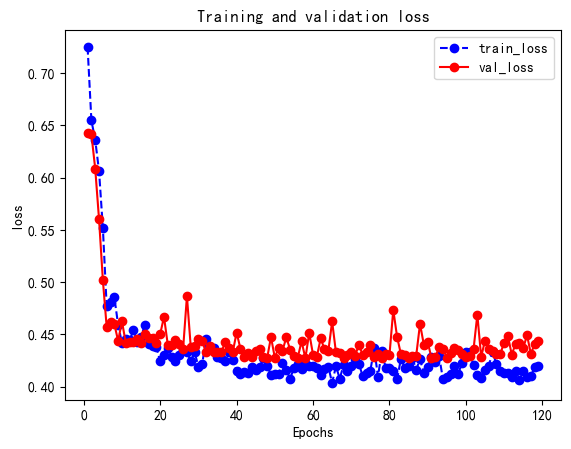

In [60]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_" + metric]
    val_metrics = dfhistory['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()


df_history = pd.DataFrame(history)
plot_metric(df_history, "loss")

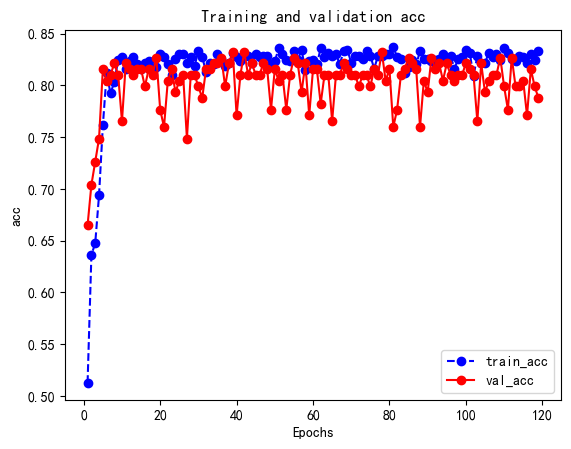

In [61]:
plot_metric(df_history, "acc")

In [48]:
# 添加缺失的 'Deck_T' 特征
test_df['Deck_T'] = 0

# 确保列顺序与训练数据一致
test_df = test_df[train_df.columns]

# 创建测试张量
X_test = torch.from_numpy(test_df.values).float()
print(f"测试数据维度：{X_test.shape}")

(418, 35)
测试数据维度：torch.Size([418, 35])


In [51]:
# 预测
model.eval()
y_pred_logits = model(X_test)
y_pred_probs = torch.sigmoid(y_pred_logits).data
y_pred = (y_pred_probs > 0.5).int()
y_pred = y_pred.numpy()
print(y_pred)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]


In [53]:
# 创建 submission DataFrame
submission_df = pd.DataFrame({
    'PassengerId': test_raw['PassengerId'],
    'Survived': y_pred.flatten()  # 确保 y_pred 是一维数组
})
print(submission_df.head())

# 验证长度是否匹配
assert len(submission_df) == len(test_raw), "PassengerId 和 Survived 的长度不匹配！"

# 保存为 CSV 文件（无索引）
submission_df.to_csv(r'../../output/submission_titanic_v1.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
